### Problem and Background: 
#### ACME is one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges. At ACME we thrive for making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.
### Data: 
#### Data is from a survey to a select customer cohort. there are 6 attributes and 1 target variable. Attributes indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.
### Goal(s): 
#### Predict if a customer is happy or not based on the answers they give to questions asked.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn.metrics import classification_report, confusion_matrix ,plot_confusion_matrix , roc_curve,auc,balanced_accuracy_score,cohen_kappa_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


In [2]:
#Read the data
data=pd.read_csv("ACME-HappinessSurvey2020.csv")


In [3]:
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.


### Statistical summary

In [7]:
data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


#### Data distribution 

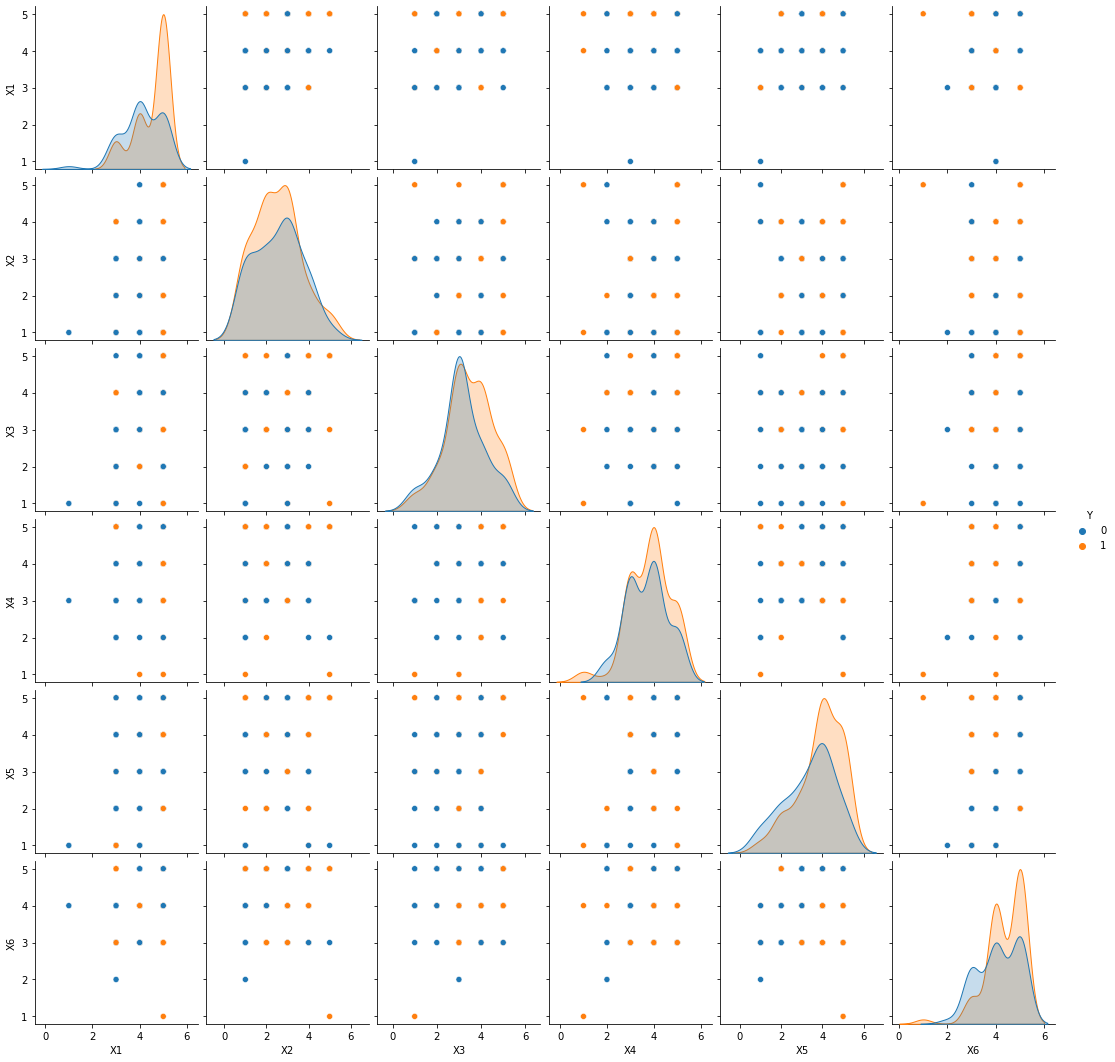

In [9]:
#data distribution with respect to target var
sns.pairplot(data=data,hue='Y')

<AxesSubplot:ylabel='Density'>

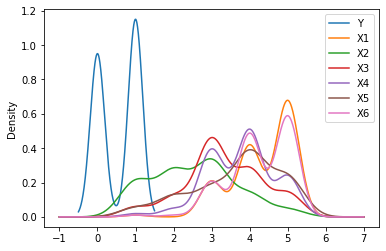

In [10]:
data.plot.kde()

Y     0     1
Y            
0  57.0   NaN
1   NaN  69.0


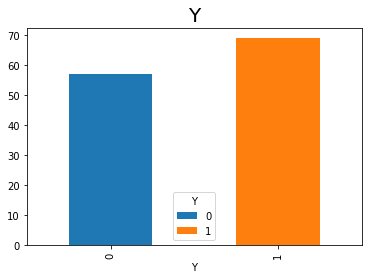

Y      0     1
X1            
1    1.0   NaN
3   12.0   8.0
4   24.0  16.0
5   20.0  45.0


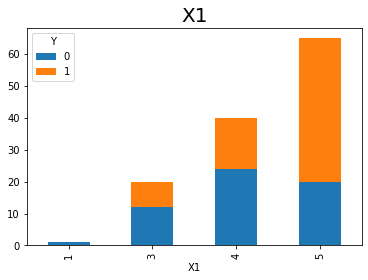

Y    0   1
X2        
1   13  14
2   13  21
3   19  23
4   10   7
5    2   4


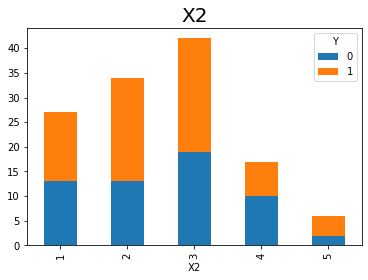

Y    0   1
X3        
1    4   3
2    7   7
3   29  26
4   11  22
5    6  11


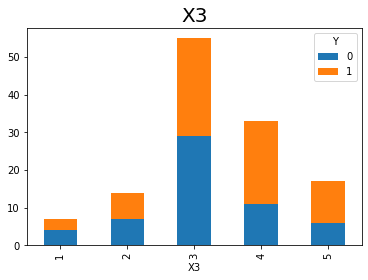

Y      0     1
X4            
1    NaN   2.0
2    4.0   1.0
3   20.0  21.0
4   23.0  30.0
5   10.0  15.0


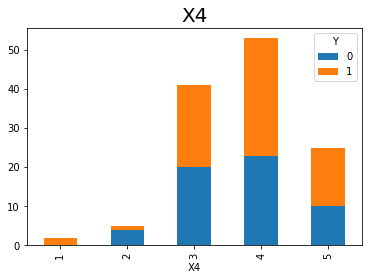

Y    0   1
X5        
1    5   2
2    9   7
3   12  10
4   22  28
5    9  22


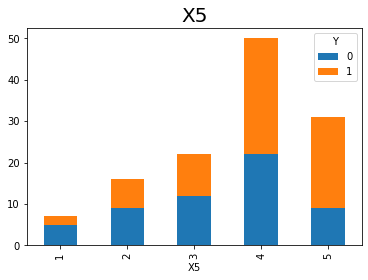

Y      0     1
X6            
1    NaN   1.0
2    1.0   NaN
3   14.0   6.0
4   20.0  27.0
5   22.0  35.0


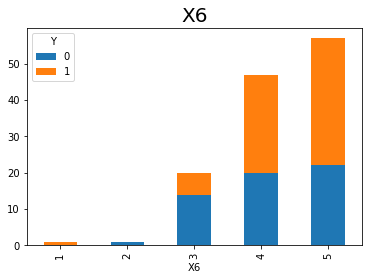

In [40]:
for i in data:
    data_group=data.groupby([i,'Y'],sort=True)['Y'].count().unstack()
    print(data_group)
    ax = data_group.plot(kind='bar', stacked=True)
    ax.axes.set_title(i,fontsize=20)
    plt.show()

#### Normality test

In [5]:
from scipy.stats import anderson
for i in data:
    res = anderson(data[i])
    ix=len(res.critical_values)-1
    if res.statistic < res.critical_values[ix]:
        print('Data is normal-fail to reject H0')
    else:
        print('Data is not normal -reject H0')

Data is not normal -reject H0
Data is not normal -reject H0
Data is not normal -reject H0
Data is not normal -reject H0
Data is not normal -reject H0
Data is not normal -reject H0
Data is not normal -reject H0


#### Correlation/dependence 

In [6]:
data.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


<AxesSubplot:>

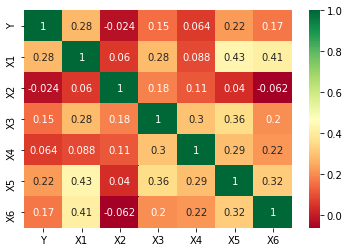

In [7]:
sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

Balanced dataset.69 customers are happy and 57 are not. 

Data is not normal 

Target variable Y NOT strongly correlated with any independent variables.

X5 and X1 are moderately correlated.

X6 and X1 are moderately correlated.

In [ ]:
from scipy.stats import zscore
in_vars=['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
data_norm=data[in_vars].apply(zscore)
data_norm

### Feature Selection

In [14]:
#RFE Method
in_vars=list(data)[1:7]
logit_model=LogisticRegression(solver='liblinear',random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data[in_vars], data['Y'], test_size = 0.2, random_state = 0)
#no of features
nof_list=np.arange(1,6)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    rfe_selector = RFE(logit_model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe_selector.fit_transform(X_train,y_train)
    X_test_rfe = rfe_selector.transform(X_test)
    logit_model.fit(X_train_rfe,y_train)
    score = logit_model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 2
Score with 2 features: 0.615385


In [9]:
#Embedded Feature selection LASSO.
lasso_reg=LassoCV(cv=10).fit(X_train, y_train)
coef = pd.Series(lasso_reg.coef_, index = X_train.columns)
print(coef)

X1    0.065928
X2   -0.000000
X3    0.042958
X4    0.000000
X5    0.013942
X6    0.000000
dtype: float64


#### Data model 1 : Logistic Regresion (RFE feature selection)

Training Data
              precision    recall  f1-score   support

           0       0.25      0.61      0.35        18
           1       0.88      0.60      0.71        82

    accuracy                           0.60       100
   macro avg       0.56      0.60      0.53       100
weighted avg       0.76      0.60      0.65       100

Test Data
              precision    recall  f1-score   support

           0       0.31      0.80      0.44         5
           1       0.92      0.57      0.71        21

    accuracy                           0.62        26
   macro avg       0.62      0.69      0.58        26
weighted avg       0.80      0.62      0.66        26

0.6857142857142857


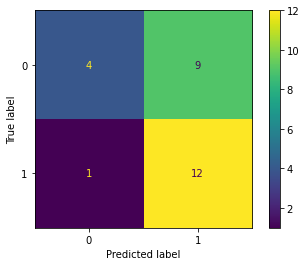

[[0.18773685 0.20605563]]


In [15]:
#logistic reg model
in_vars=list(data)[1:7]

X_train, X_test, y_train, y_test = train_test_split(data[in_vars], data['Y'], test_size = 0.2, random_state = 0)

rfe_selector = RFE(logit_model,n_features_to_select=2)
rfe_x_train = rfe_selector.fit_transform(X_train,y_train)
logit = LogisticRegression(solver='liblinear', random_state=0).fit(rfe_x_train, y_train)
y_train_pred=logit.predict(rfe_x_train)
rfe_x_test = rfe_selector.transform(X_test)
y_pred=logit.predict(rfe_x_test)
#logit.score(x_test, y_test)
print("Training Data")
print(classification_report(y_train_pred, y_train))
print("Test Data")
print(classification_report(y_pred, y_test))
print(balanced_accuracy_score(y_pred, y_test))
plot_confusion_matrix(logit, rfe_x_test, y_test)   
plt.show() 
print(logit.coef_)

#### Significant Features

In [12]:
print(in_vars)
print(rfe_selector.support_)
print(rfe_selector.ranking_)


['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
[ True False  True False False False]
[1 3 1 5 4 2]


#### Data model 2: GBM with lasso  feature selection

Training Data
              precision    recall  f1-score   support

           0       0.66      0.64      0.65        45
           1       0.71      0.73      0.72        55

    accuracy                           0.69       100
   macro avg       0.69      0.69      0.69       100
weighted avg       0.69      0.69      0.69       100

Test Data
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.69      0.64      0.67        14

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26

0.6547619047619048


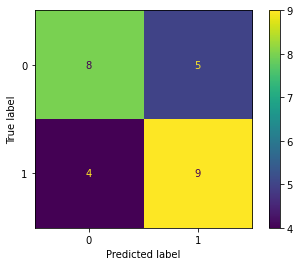

In [16]:
#GBM Model with Lasso embedded feature selection
in_vars=['X1','X3','X5']

X_train, X_test, y_train, y_test = train_test_split(data[in_vars], data['Y'], test_size = 0.2, random_state = 0)
from sklearn.ensemble import GradientBoostingClassifier

GBM_model=GradientBoostingClassifier(n_estimators=20, learning_rate=.05, max_features=2, max_depth=2, random_state=0).fit(X_train, y_train)
#GBM_model=GradientBoostingClassifier(n_estimators=20, learning_rate=.15, max_features=2, max_depth=2, random_state=0)
#scores = cross_val_score(GBM_model, rfe_x_train, y_train, cv=5)
#print(scores)
y_train_pred=GBM_model.predict(X_train)
y_pred=GBM_model.predict(X_test)
print("Training Data")
print(classification_report(y_train_pred, y_train))
print("Test Data")
print(classification_report(y_pred, y_test))
print(balanced_accuracy_score(y_pred, y_test))
plot_confusion_matrix(GBM_model, X_test, y_test)   
plt.show() 

#### Data model 3 : Support Vector Classifier  (RFE feature selection)

Training Data
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        53
           1       0.61      0.72      0.66        47

    accuracy                           0.65       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.66      0.65      0.65       100

Test Data
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.69      0.75      0.72        12

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26

0.7321428571428572


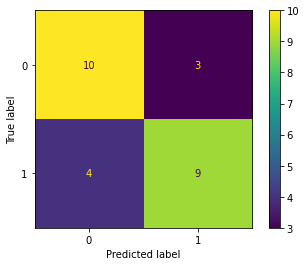

In [17]:
from sklearn.svm import SVC
svc_model=SVC(kernel='rbf').fit(rfe_x_train, y_train)
y_train_pred=svc_model.predict(rfe_x_train)
y_pred=svc_model.predict(rfe_x_test)
print("Training Data")
print(classification_report(y_train_pred, y_train))
print("Test Data")
print(classification_report(y_pred, y_test))
print(balanced_accuracy_score(y_pred, y_test))
plot_confusion_matrix(svc_model, rfe_x_test, y_test)   
plt.show() 

#### Data model 4 : kNN Classifier (RFE feature selection)

Training Data
              precision    recall  f1-score   support

           0       0.64      0.61      0.62        46
           1       0.68      0.70      0.69        54

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.66      0.66      0.66       100

Test Data
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.77      0.77      0.77        13

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26

0.7692307692307693


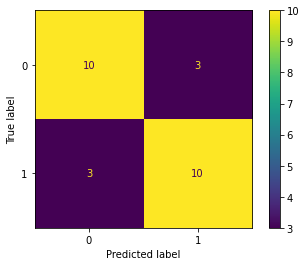

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate,cross_val_score
kNN_model=KNeighborsClassifier(n_neighbors=7).fit(rfe_x_train, y_train)
y_train_pred=kNN_model.predict(rfe_x_train)
y_pred=kNN_model.predict(rfe_x_test)
print("Training Data")
print(classification_report(y_train_pred, y_train))
print("Test Data")
print(classification_report(y_pred, y_test))
print(balanced_accuracy_score(y_pred, y_test))
plot_confusion_matrix(kNN_model, rfe_x_test, y_test)   
plt.show() 

#### Data model 5 : Gradient Boosting Classifier (RFE feature selection)

Training Data
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        45
           1       0.70      0.71      0.70        55

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.67      0.67      0.67       100

Test Data
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.77      0.71      0.74        14

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26

0.7321428571428572


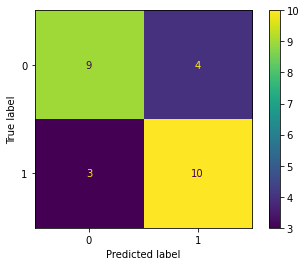

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
GBM_model=GradientBoostingClassifier(n_estimators=18, learning_rate=.11, max_features=2, max_depth=2, random_state=0).fit(rfe_x_train, y_train)
#GBM_model=GradientBoostingClassifier(n_estimators=20, learning_rate=.15, max_features=2, max_depth=2, random_state=0)
#scores = cross_val_score(GBM_model, rfe_x_train, y_train, cv=5)
#print(scores)
y_train_pred=GBM_model.predict(rfe_x_train)
y_pred=GBM_model.predict(rfe_x_test)
print("Training Data")
print(classification_report(y_train_pred, y_train))
print("Test Data")
print(classification_report(y_pred, y_test))
print(balanced_accuracy_score(y_pred, y_test))
plot_confusion_matrix(GBM_model, rfe_x_test, y_test)   
plt.show() 

### Analysis and Insights 

1. The proportion of happy customers is slightly higher than unhappy customer.

1. Most customers got their order delivered on time. It is evident from the data that when an order is delivered late, most customers seems unhappy. Most cutomers who recieved the order on time are happy.  

1. The contents most customers received was NOT as they expected. Eventhough the items are not as expected, the customers seems to be happy, which means this is not a very significant factor that influences the customer happiness with the order. 

1. Most customers who ordered everything they wanted appear to be happy.

1. Most customers believe they paid a moderate price for the order.

1. Satisfied customers are happy customers. 

1. Most users consider that the app is very friendly but that does not have a significant impact on customer happiness. 


It is possible to predict if a customer is happy or not with about 73% accuracy using 2 attributes, X1(my order was delivered on time) and X3(I ordered everything I wanted to order). Support Vector Classifier(radial based fun kernal) , and Gradient Boosting Classifier model gave a test accuracy of 73 percentage. kNearest Neighbour Classifier with k=7  gave an accuracy of 77%.

 

##### Support Vector Classifier and Gradient Bossting Classifier can be used for classifying the happy and unhappy customers with moderate accuracy of about 73% with  just 2 features X1 = my order was delivered on time and X3 = I ordered everything I wanted to order.